# 021_MC_blackjack_FirstVisit
## Suntton p.92 First-Visit MC predictions, for estimating V ~ v_pi
<img src="https://miro.medium.com/max/1400/1*ILNp-qVAAohsOE2_rpWE2A.png" width=600/>

## 주어진 Policy를 평가하기 위한 알고리즘

### card 조합에 따른 State Value estimate

First-Visit MC Algorithm 을 이용하여 Blackjack game 의 모든 State Value 계산

- Input : 평가 대상인 policy 𝜋

- Random value 로 V 생성하고, 모든 state 에 대한 return 을 저장할 empty Returns[S] list 생성

- Policy 를 이용하여 episode 생성

- 에피소드 각 state 마다 first state 부터 이전 state (𝑆_(𝑡−1)) 까지의 return 을 더한다.

- 합한 return 을 평균하여 value 평가를 한다.

In [2]:
import gym 
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

#state : (player card sum, dealer open card, usable_ace 보유) ex) (6, 1, False)
stick_threshold = 19
win_cnt = 0
lose_cnt = 0
draw_cnt = 0
num_episodes = 100_000
GAMMA = 1  # no discount

env = gym.make("Blackjack-v0")

In [3]:
# Input: a policy pi to be evaluated
def pi(state):
    # state : (player card sum, dealer open card, usable_ace 보유) ex) (6, 1, False)
    # player card 가 stick_threshold 이상이면 무조건 stick 하고
    # else 이면 hit 하는 전략
    #0:stick, 1:hit
    return 0 if state[0] >= stick_threshold else 1  

# Initialize V(s)
# Returns(s) <- empty list for all s
V = defaultdict(float)
Returns = defaultdict(list)

# Loop forever(for each episode)
for i in range(num_episodes):
    
    #Generate an episode following pi: S0,A0,R1,S1,A1,R2,..ST-1,AT-1,RT
    episode = []
    s = env.reset() # s: (sum_hand(player), dealer open card, usable_ace 보유)
    while True:
        a = pi(s)  # 정책 pi 를 따름
        s_, r, done, _ = env.step(a) 
        episode.append((s, a, r))
        if done:
            if r == 1:
                win_cnt += 1
            elif r == -1:
                lose_cnt += 1
            else:
                draw_cnt += 1
            break
        s = s_
        
    #G <- 0
    G = 0
    #Loop for each step of spisode: t=T-1,T-2,...,0
    for s, a, r in episode[::-1]:
        #G <- gamma*G + R_(t+1)
        G = GAMMA * G + r  
        visited_states = []
        #Unless S_t appears in S_0, S_1,...S_(t-1):          
        if s not in visited_states:
            #Append G to Returns(S_t)
            Returns[s].append(G)
            #V(S_t) <- average(Returns(S_t))
            V[s] = np.mean(Returns[s])
            visited_states.append(s)    
            
    if i % 5000 == 0:
        print(f"episode {i} completed...") 

episode 0 completed...
episode 5000 completed...
episode 10000 completed...
episode 15000 completed...
episode 20000 completed...
episode 25000 completed...
episode 30000 completed...
episode 35000 completed...
episode 40000 completed...
episode 45000 completed...
episode 50000 completed...
episode 55000 completed...
episode 60000 completed...
episode 65000 completed...
episode 70000 completed...
episode 75000 completed...
episode 80000 completed...
episode 85000 completed...
episode 90000 completed...
episode 95000 completed...


In [4]:
print('stick threshold = {}'.format(stick_threshold))
print("win ratio = {:.2f}%".format(win_cnt/num_episodes*100))
print("lose ratio = {:.2f}%".format(lose_cnt/num_episodes*100))
print("draw ratio = {:.2f}%".format(draw_cnt/num_episodes*100))

stick threshold = 19
win ratio = 35.90%
lose ratio = 56.47%
draw ratio = 7.63%


In [5]:
sample_state = (21, 3, True)
print(f"player가 손에 {sample_state[0]}를 들고 dealer가 {sample_state[1]}를 보여주고 있을 때")
print("\tstate {}의 가치 = {:.2f}".format(sample_state, V[sample_state]))

sample_state = (14, 1, False)
print(f"player가 손에 {sample_state[0]}를 들고 dealer가 {sample_state[1]}를 보여주고 있을 때")
print("\tstate {}의 가치 = {:.2f}".format(sample_state, V[sample_state]))

player가 손에 21를 들고 dealer가 3를 보여주고 있을 때
	state (21, 3, True)의 가치 = 0.86
player가 손에 14를 들고 dealer가 1를 보여주고 있을 때
	state (14, 1, False)의 가치 = -0.64


## Blackjack state value 시각화
- np.meshgrid : 1차원 좌표 array 에서 N 차원 직사각형 격자 생성  
- np.dstack : 2 차원 array를 3차원 array 로 stacking. (M, N) → (M, N, 1) 변환 후 3rd axis 를 depth-wise stack  
- np.apply_along_axis : 주어진 축을 따라 1차원 슬라이스에 함수를 적용

In [41]:
#시각화
X, Y = np.meshgrid(
    np.arange(1, 11),    # dealer가 open 한 card (1~10) - dealer open card
    np.arange(12, 22))   # player가 가진 card 합계 (12~21) - sum_hand(player)
print(X.shape, Y.shape)
# print(X); print(Y)
card_states = np.dstack([X, Y])
print(card_states.shape)
# print(card_states)

(10, 10) (10, 10)
(10, 10, 2)


In [44]:
#V[(sum_hand(player), dealer open card, usable_ace 보유)]
no_usable_ace = np.apply_along_axis(lambda idx: V[(idx[1], idx[0], False)],  2, card_states)
usable_ace    = np.apply_along_axis(lambda idx: V[(idx[1], idx[0], True)], 2, card_states)

print(no_usable_ace.shape, usable_ace.shape)

(10, 10) (10, 10)


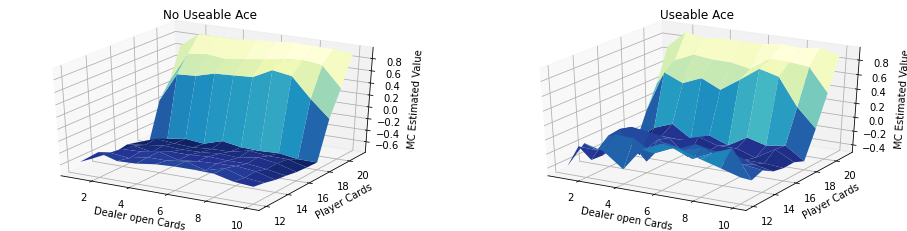

In [45]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 4), subplot_kw={'projection': '3d'})

ax0.plot_surface(X, Y, no_usable_ace, cmap=plt.cm.YlGnBu_r)
ax0.set_xlabel('Dealer open Cards')
ax0.set_ylabel('Player Cards')
ax0.set_zlabel('MC Estimated Value')
ax0.set_title('No Useable Ace')

ax1.plot_surface(X, Y, usable_ace, cmap=plt.cm.YlGnBu_r)
ax1.set_xlabel('Dealer open Cards')
ax1.set_ylabel('Player Cards')
ax1.set_zlabel('MC Estimated Value')
ax1.set_title('Useable Ace')
    
plt.show()